<a href="https://colab.research.google.com/github/kamhar-ngado/Track/blob/master/Program_auto_pilot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!git clone https://github.com/kamhar-ngado/Track

fatal: destination path 'Track' already exists and is not an empty directory.


In [41]:
!ls Track

driving_log.csv  IMG  Program_auto_pilot.ipynb	README.md


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras 
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
import cv2
import pandas as pd
import ntpath
import random

In [43]:
datadir = 'Track'
colomns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = colomns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\self driving car simulator\IMG\center_2019_12_21_15_25_24_879.jpg,C:\self driving car simulator\IMG\left_2019_12_21_15_25_24_879.jpg,C:\self driving car simulator\IMG\right_2019_12_21_15_25_24_879.jpg,0.0,0.0,0.0,0.000078
1,C:\self driving car simulator\IMG\center_2019_12_21_15_25_25_021.jpg,C:\self driving car simulator\IMG\left_2019_12_21_15_25_25_021.jpg,C:\self driving car simulator\IMG\right_2019_12_21_15_25_25_021.jpg,0.0,0.0,0.0,0.000084
2,C:\self driving car simulator\IMG\center_2019_12_21_15_25_25_128.jpg,C:\self driving car simulator\IMG\left_2019_12_21_15_25_25_128.jpg,C:\self driving car simulator\IMG\right_2019_12_21_15_25_25_128.jpg,0.0,0.0,0.0,0.000078
3,C:\self driving car simulator\IMG\center_2019_12_21_15_25_25_240.jpg,C:\self driving car simulator\IMG\left_2019_12_21_15_25_25_240.jpg,C:\self driving car simulator\IMG\right_2019_12_21_15_25_25_240.jpg,0.0,0.0,0.0,0.000078
4,C:\self driving car simulator\IMG\center_2019_12_21_15_25_25_342.jpg,C:\self driving car simulator\IMG\left_2019_12_21_15_25_25_342.jpg,C:\self driving car simulator\IMG\right_2019_12_21_15_25_25_342.jpg,0.0,0.0,0.0,0.000080


In [44]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_12_21_15_25_24_879.jpg,left_2019_12_21_15_25_24_879.jpg,right_2019_12_21_15_25_24_879.jpg,0.0,0.0,0.0,0.000078
1,center_2019_12_21_15_25_25_021.jpg,left_2019_12_21_15_25_25_021.jpg,right_2019_12_21_15_25_25_021.jpg,0.0,0.0,0.0,0.000084
2,center_2019_12_21_15_25_25_128.jpg,left_2019_12_21_15_25_25_128.jpg,right_2019_12_21_15_25_25_128.jpg,0.0,0.0,0.0,0.000078
3,center_2019_12_21_15_25_25_240.jpg,left_2019_12_21_15_25_25_240.jpg,right_2019_12_21_15_25_25_240.jpg,0.0,0.0,0.0,0.000078
4,center_2019_12_21_15_25_25_342.jpg,left_2019_12_21_15_25_25_342.jpg,right_2019_12_21_15_25_25_342.jpg,0.0,0.0,0.0,0.000080


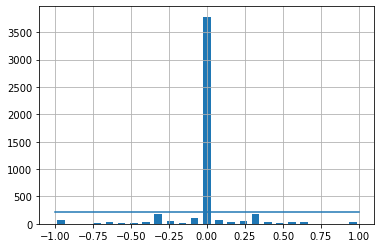

In [45]:
num_bins = 25
samples_per_bin = 210
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
plt.grid()

total data: 4837
removed: 3572
remaining: 1265


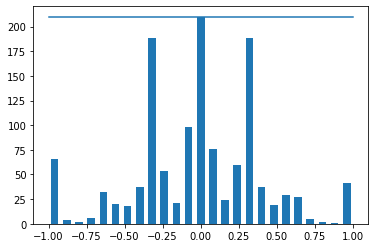

In [46]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))